In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm

In [2]:
from rg_dataset import LRG, UNLRG_C

In [3]:
data_set = LRG(use_kittler=True, twice=True)
data_loader = data.DataLoader(data_set, batch_size=64, shuffle=False)
sample = iter(data_loader).next()

LRG:	1442/1442


In [4]:
len(sample)

3

In [46]:
class VAE(nn.Module):
    def __init__(self, lt_dim=11):
        super(VAE, self).__init__()
        self.k = [1, 16, 32, 128, 512, 1024]
        encoder_layers = []
        decoder_layers = []
        
        for i in range(len(self.k) - 1):
            layer = nn.Conv2d(self.k[i], self.k[i+1], 3, 2, 1, 1)
            encoder_layers.append(layer)
            encoder_layers.append(nn.ReLU())
        
        for i in range(len(self.k) - 1, 0, -1):
            layer = nn.ConvTranspose2d(self.k[i], self.k[i-1], 3, 2, 1, 1)
            decoder_layers.append(layer)
            decoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Linear(self.k[-1]*2*2, lt_dim)
        self.fc_ep = nn.Linear(self.k[-1]*2*2, lt_dim)
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    def encode(self, x):
        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [47]:
class VAE_loss:
    def __init__(self):
        self.recon_ls = nn.BCELoss(reduction='sum')
    def update(self):
        pass
    def __call__(self, res, img):
        batch_sz = len(img)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return 0, recon, kld

class Beta_vae_loss:
    def __init__(self, gamma, max_capacity, epochs):
        self.gamma = gamma
#         self.recon_ls = nn.MSELoss(reduction='sum')
        self.recon_ls = nn.BCELoss(reduction='sum')
        self.capacity = 0
        self.delta = max_capacity / float(epochs)
        self.max_capacity = max_capacity
    def update(self):
        self.capacity = min(self.max_capacity, self.capacity + self.delta)
        return self.capacity
    def __call__(self, res, img):
        batch_sz = len(img)
#         print(res.shape)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return self.capacity, recon, self.gamma * (kld - self.capacity).abs()

In [48]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    b_count = 0
    for batch_idx, (data, data_dup, target) in enumerate(data_loader):
        b_count += len(data)
        data     = data.to(device)
        data_dup = data_dup.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optimizer.zero_grad()
        output   = model(data)
        output_2 = model(data_dup)
        
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
        extended = target > 1
        extended = Variable(extended.float().to(device), requires_grad=False)
        pred_ext = torch.sigmoid(output[1][:,0])
        ext_loss = F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))
        pred_ext = torch.sigmoid(output_2[1][:,0])
        ext_loss += F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))
        loss = ext_loss
        
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss += r_loss + g_loss
        c, r_loss , g_loss = beta_vae_loss(output_2, data)
        loss += r_loss + g_loss
        #Add loss of encode difference in all but last two params
        sim = F.mse_loss(output[1][:, :-1], output_2[1][:, :-1], reduction='sum').div(len(data))
        loss += sim.div(10)
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {:3d} [{:6d}/{:6d} ({:3.0f}%)    Loss: {:5.4f}    R_Loss: {:5.4f}    Capacity: {:3.4f}'
        s = s.format(epoch, b_count, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item(), sim.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [49]:
device = 'cuda'

vae = VAE().to(device)
optimizer = Adam(vae.parameters(), lr=0.001)
epochs = 50

In [50]:
beta_vae_loss = Beta_vae_loss(gamma=4, max_capacity=10, epochs=epochs)
# beta_vae_loss = VAE_loss() 
for epoch in range(1, epochs+1):
    start = time.time()
    s = train_step(vae, 'cuda' ,data_loader, optimizer, epoch)
    beta_vae_loss.update()
    t = time.time() - start
    sys.stdout.write('{0}    Time {1:3.2f}s\n'.format(s, t))

Train Epoch:   1 [ 14420/ 14420 (100%)    Loss: 640.4827    R_Loss: 0.0723    Capacity: 0.0000    Time 35.86s
Train Epoch:   2 [ 14420/ 14420 (100%)    Loss: 607.6956    R_Loss: 0.1179    Capacity: 0.2000    Time 35.75s
Train Epoch:   3 [ 14420/ 14420 (100%)    Loss: 594.6926    R_Loss: 0.1694    Capacity: 0.4000    Time 35.77s
Train Epoch:   4 [ 14420/ 14420 (100%)    Loss: 591.5723    R_Loss: 0.3822    Capacity: 0.6000    Time 35.99s
Train Epoch:   5 [ 14420/ 14420 (100%)    Loss: 599.5141    R_Loss: 0.3789    Capacity: 0.8000    Time 35.99s
Train Epoch:   6 [ 14420/ 14420 (100%)    Loss: 590.6016    R_Loss: 0.8366    Capacity: 1.0000    Time 35.94s
Train Epoch:   7 [ 14420/ 14420 (100%)    Loss: 586.7231    R_Loss: 1.3829    Capacity: 1.2000    Time 35.90s
Train Epoch:   8 [ 14420/ 14420 (100%)    Loss: 578.5903    R_Loss: 1.3451    Capacity: 1.4000    Time 35.96s
Train Epoch:   9 [ 14420/ 14420 (100%)    Loss: 568.1276    R_Loss: 1.4128    Capacity: 1.6000    Time 35.94s
Train Epoc

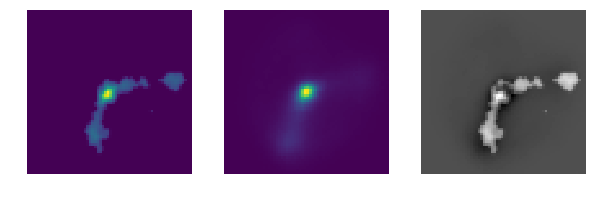

tensor([[0.5748, 0.4022, 0.8922, 0.3912, 0.4927, 0.3458, 0.3262, 0.2395, 0.4664,
         0.5773, 0.3785]], device='cuda:0') tensor([4])


In [60]:
a = 1#6
s, l = sample[0][a:a+1], sample[2][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

print(torch.sigmoid(e), l)
# sample

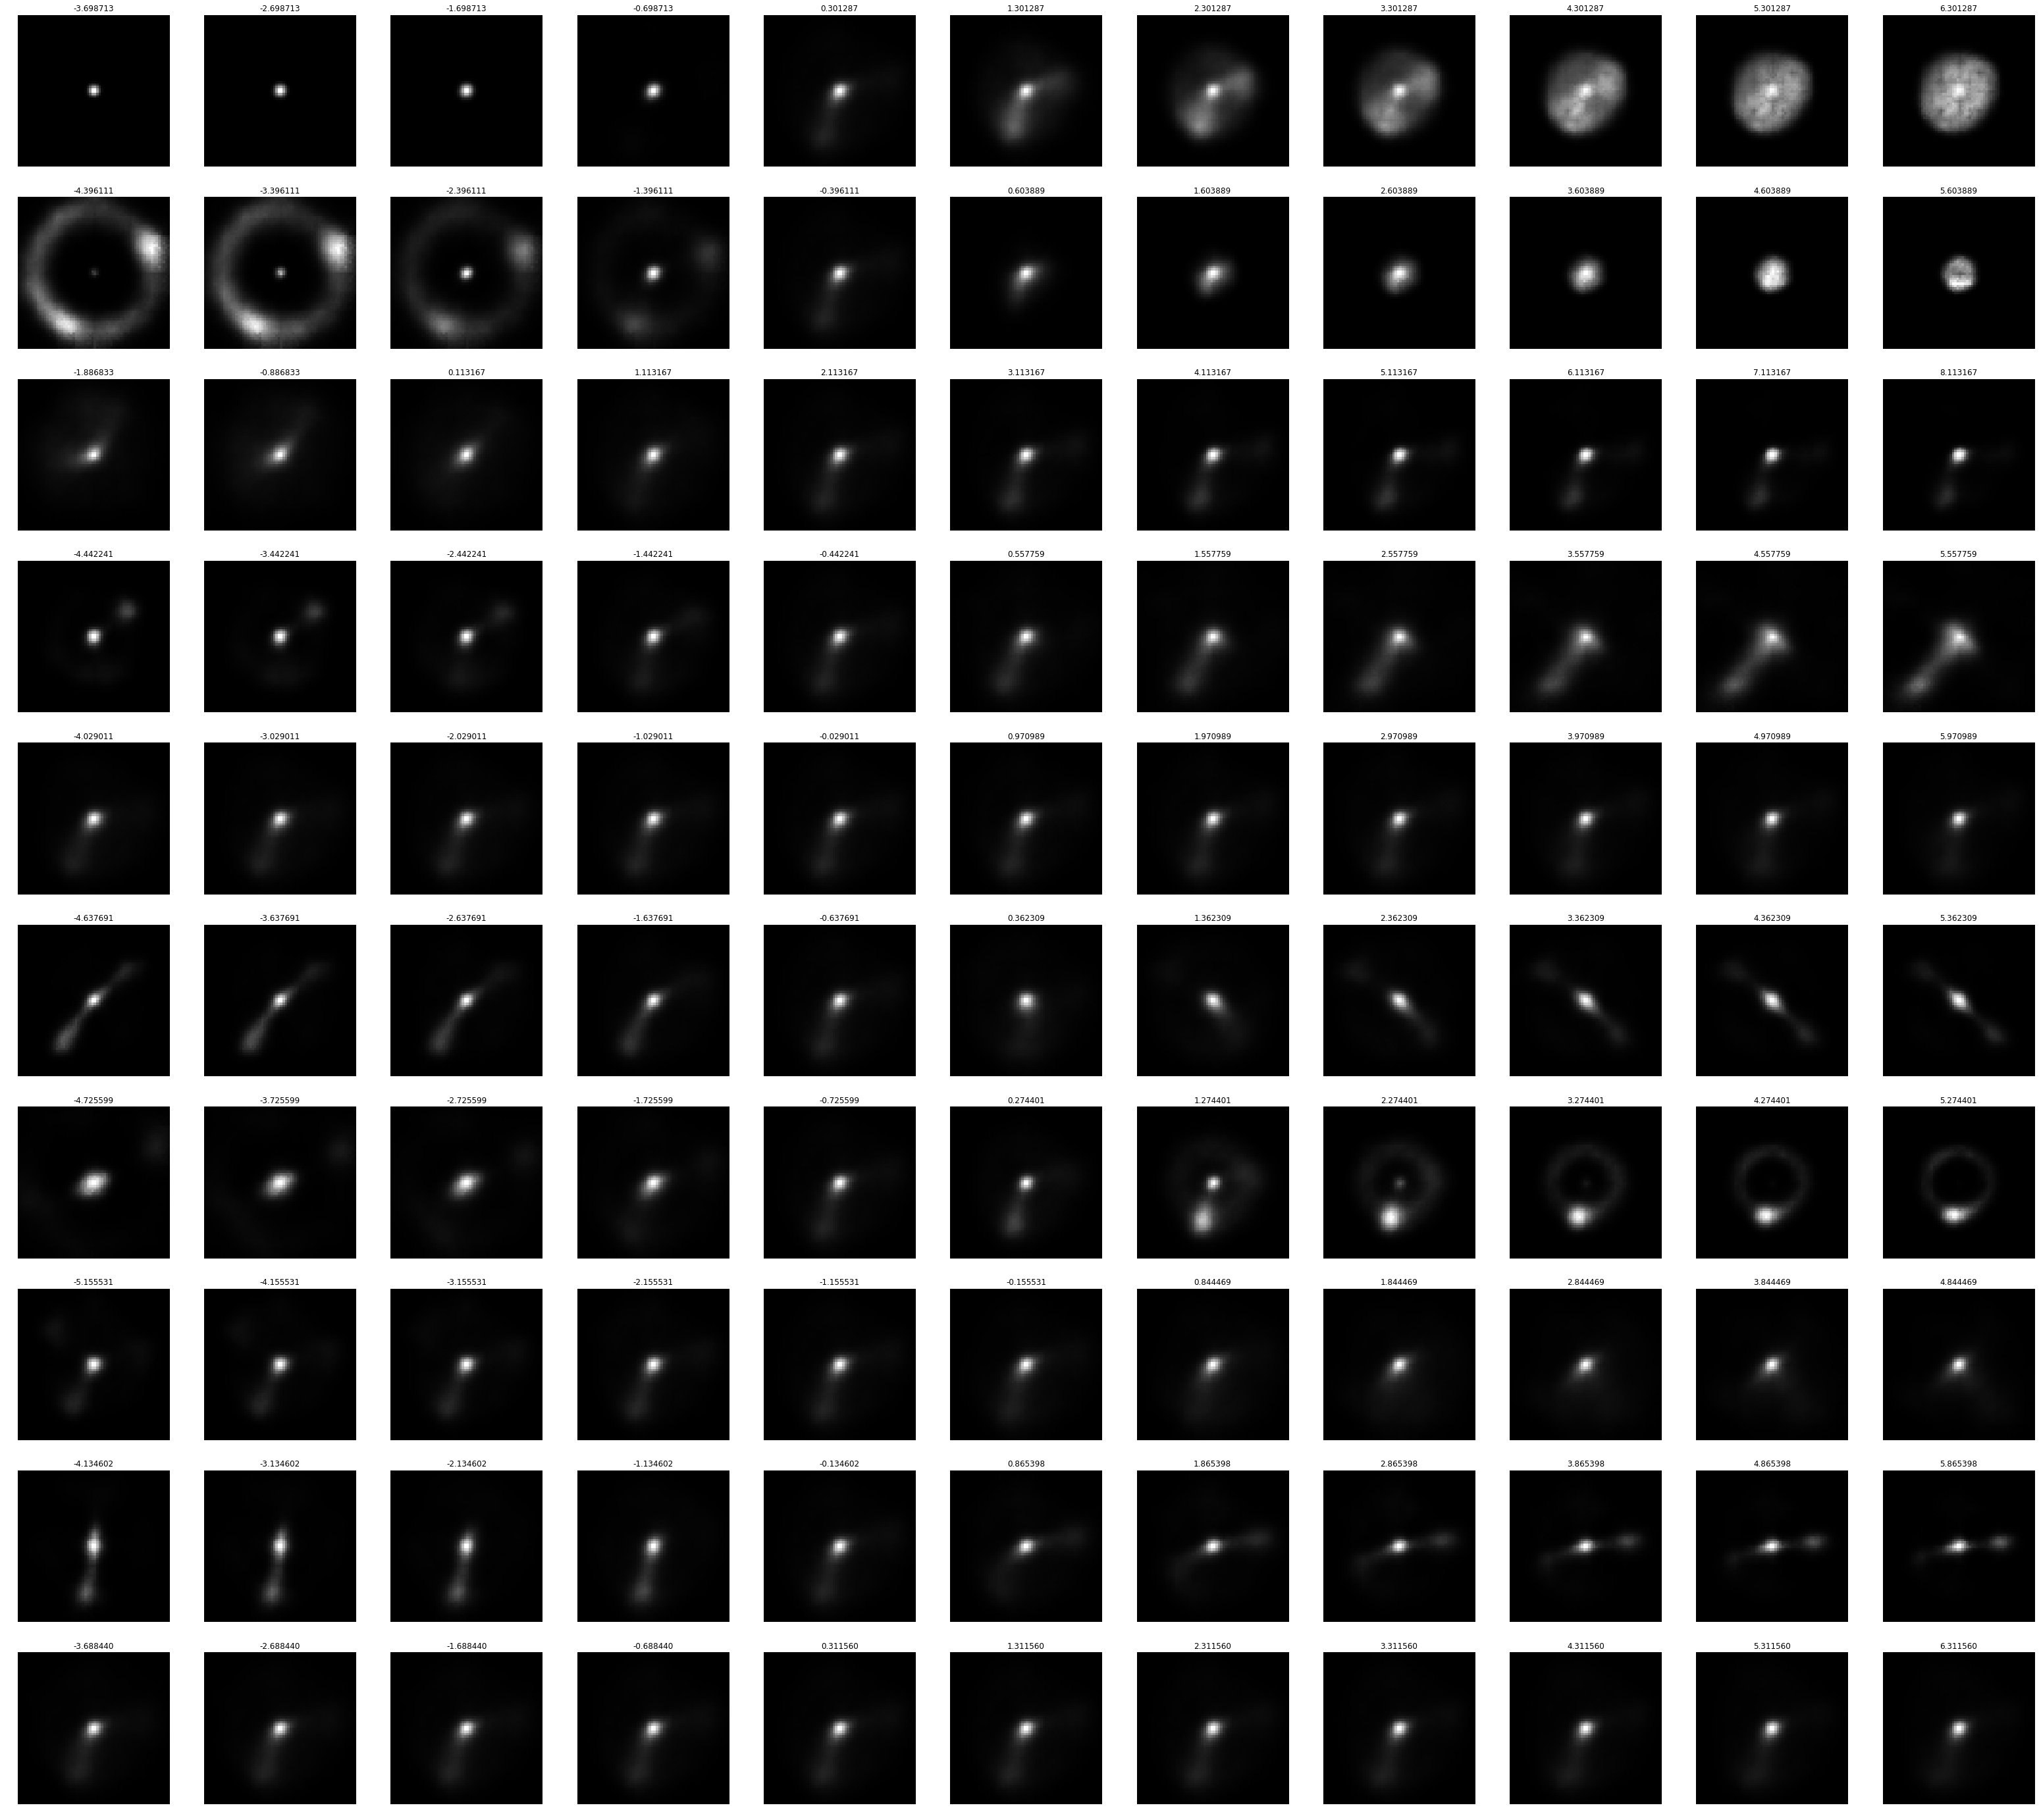

In [52]:
r = 11
nimg = r * 10
k=4
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        with torch.no_grad():
            e = vae.encode(s.to(device))[0]
            v = e[0][i]
            nv = -1*k + v + k*j/4
            e[0][i] = nv
            d = vae.decode(e).cpu()[0][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))

In [ ]:
sample = iter(data_loader).next()
r = 10
nimg = r * 10
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        ax[i][j].imshow(sample[0][i*r+j][0], cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))

In [61]:
torch.save(vae, 'b_vae_rot_model')